# get annotations - sentences

In [417]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import time
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [387]:
from bert_serving.client import BertClient
bc = BertClient()

# load dataset with encodings

In [388]:
dataset_path = Path('../../data')

In [389]:
full_ann_df = pd.read_pickle(str(dataset_path/'annotations.pkl'))

In [549]:
ann_df = full_ann_df.copy() #.sample(2000) #.iloc[:1000]

In [550]:
ann_df

,sample_id,annotation,encoding
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4..."
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958..."
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635..."
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338..."
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279..."
...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005..."
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143..."
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950..."
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485..."


# do clustering

In [551]:
X = np.stack(ann_df.encoding.to_numpy(), axis=0)
X.shape

(6353, 768)

# specify some clusters manually

In [552]:
true_k = 5

In [553]:
classes = ['person is running', 'person walks slowly', 'person turns right or left', 'person moves clockwise', 'person moves hand']
centroids_df = pd.DataFrame({'pred': list(range(true_k)), 'class': classes})
centers = bc.encode(classes)
centroids_df['center_init' ] = [centers[x] for x in range(centers.shape[0])]
centroids_df

,pred,class,center_init
0,0,person is running,"[-0.44440597, -0.42228192, -0.100142516, -0.10..."
1,1,person walks slowly,"[-0.6239433, -0.10096745, 0.07507296, -0.11933..."
2,2,person turns right or left,"[-0.7818436, -0.18205455, 0.4012735, -0.314156..."
3,3,person moves clockwise,"[-0.73051995, -0.26687098, 0.26984498, -0.5033..."
4,4,person moves hand,"[-1.1898891, -0.13088067, 0.56945527, -0.34379..."


In [554]:
center_init_arr = np.stack(centroids_df.center_init.to_numpy(), axis=0)
center_init_arr.shape

(5, 768)

In [555]:
time_start = time.time()
# kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
kmeans = KMeans(n_clusters=true_k, init=center_init_arr, max_iter=1, n_init=1)
# kmeans.fit(X)
# print('k-means done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [556]:
# compute distances

In [557]:
v1 =center_init_arr[0:2]
v1.shape

(2, 768)

In [558]:
def assign_cluster(vec, centers):
#     dist = euclidean_distances(vec, centers)
    dist = cosine_similarity(vec, centers)
    print(dist)
#     return np.argmin(dist, axis=1)
    return np.argmax(dist, axis=1)
assign_cluster(v1, center_init_arr)

[[0.9999997  0.8546585  0.659535   0.834826   0.8389057 ]
 [0.8546585  1.         0.7230722  0.849975   0.90102285]]


array([0, 1])

In [559]:
# centroids_df = pd.DataFrame({'pred': list(range(true_k))})
# centers = kmeans.cluster_centers_
centers = center_init_arr
centroids_df['center'] = [centers[x] for x in range(centers.shape[0])]
centroids_df

,pred,class,center_init,center
0,0,person is running,"[-0.44440597, -0.42228192, -0.100142516, -0.10...","[-0.44440597, -0.42228192, -0.100142516, -0.10..."
1,1,person walks slowly,"[-0.6239433, -0.10096745, 0.07507296, -0.11933...","[-0.6239433, -0.10096745, 0.07507296, -0.11933..."
2,2,person turns right or left,"[-0.7818436, -0.18205455, 0.4012735, -0.314156...","[-0.7818436, -0.18205455, 0.4012735, -0.314156..."
3,3,person moves clockwise,"[-0.73051995, -0.26687098, 0.26984498, -0.5033...","[-0.73051995, -0.26687098, 0.26984498, -0.5033..."
4,4,person moves hand,"[-1.1898891, -0.13088067, 0.56945527, -0.34379...","[-1.1898891, -0.13088067, 0.56945527, -0.34379..."


In [560]:
len(X)

6353

In [561]:
# prediction = kmeans.predict(Y)
prediction = assign_cluster(X, center_init_arr)
print(prediction[:10])

ann_df['pred'] = prediction

[[0.7856624  0.7916099  0.67515755 0.77623975 0.7372924 ]
 [0.80115837 0.8440799  0.7057952  0.83230877 0.7894655 ]
 [0.80149764 0.742052   0.5277588  0.680768   0.67189544]
 ...
 [0.7417466  0.72843975 0.688533   0.70773447 0.68739676]
 [0.741693   0.7442799  0.6929154  0.7163395  0.7252085 ]
 [0.77808934 0.76210165 0.6975272  0.71540534 0.71970665]]
[1 1 0 1 1 1 1 1 1 3]


In [562]:
ann_df

,sample_id,annotation,encoding,pred
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...",1
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...",1
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...",0
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...",1
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...",1
...,...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005...",0
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143...",0
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950...",0
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485...",1


# analyze/visualize clusters

In [563]:
Y_anns = Y_df.annotation.to_list(); Y_anns[:5]

['Someone runs forward',
 'A person walks a quarter circle clockwise with 4 steps.',
 'A person walks forward, turns on the spot and walks back.',
 'The human kicks with his left foot.',
 'A person walks two steps forwards, rotates to their left 180 degrees into the opposite direction and continues walking for two steps then stops.']

In [564]:
preds = [(ann, prediction[idx]) for idx, ann in enumerate(Y_anns)]; preds[:5]

[('Someone runs forward', 1),
 ('A person walks a quarter circle clockwise with 4 steps.', 1),
 ('A person walks forward, turns on the spot and walks back.', 0),
 ('The human kicks with his left foot.', 1),
 ('A person walks two steps forwards, rotates to their left 180 degrees into the opposite direction and continues walking for two steps then stops.',
  1)]

In [565]:
for x in range(1, true_k+1):
    pprint([p for p in preds if p[1]==x][:20])
    print()

[('Someone runs forward', 1),
 ('A person walks a quarter circle clockwise with 4 steps.', 1),
 ('The human kicks with his left foot.', 1),
 ('A person walks two steps forwards, rotates to their left 180 degrees into '
  'the opposite direction and continues walking for two steps then stops.',
  1),
 ('A human draws circles in the air.', 1),
 ('a person walks quater a circle to the right', 1),
 ('The human is streching his arms', 1),
 ('A person walking backwards', 1),
 ('A person starts to walk forward and stumbles after 2 steps.', 1),
 ('A person playing the air violine', 1),
 ('A human is walking slowly putting the right foot directly in front of the '
  'left foot. Moving slightly to the left side.',
  1),
 ('A human walks slowly a full circle to its right and ends up on the spot '
  'where it started.',
  1),
 ('A person waves with the left hand.', 1),
 ('A person walks forward', 1),
 ('the person steps to the left', 1),
 ('A person is slowly walking with the right shoulder and ar

# visualize, reduce dimensionality (T-SNE)

In [566]:
# pick, and refine centroids/classes

In [567]:
# centroids = kmeans.cluster_centers_
centroids = center_init_arr
centroids.shape

(5, 768)

In [568]:
X.shape

(6353, 768)

# append centroids, do t-sne, and then separate them

In [569]:
Xprim = np.concatenate([X, centroids], axis=0)
Xprim.shape

(6358, 768)

In [570]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_prim = tsne.fit_transform(Xprim[:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6358 samples in 0.260s...
[t-SNE] Computed neighbors for 6358 samples in 49.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6358
[t-SNE] Computed conditional probabilities for sample 2000 / 6358
[t-SNE] Computed conditional probabilities for sample 3000 / 6358
[t-SNE] Computed conditional probabilities for sample 4000 / 6358
[t-SNE] Computed conditional probabilities for sample 5000 / 6358
[t-SNE] Computed conditional probabilities for sample 6000 / 6358
[t-SNE] Computed conditional probabilities for sample 6358 / 6358
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.181030
[t-SNE] KL divergence after 300 iterations: 2.343903
t-SNE done! Time elapsed: 54.679259061813354 seconds


In [571]:
tsne_results = tsne_results_prim[:X.shape[0], :]
centroids_results = tsne_results_prim[X.shape[0]:, :]
tsne_results.shape, centroids_results.shape

((6353, 2), (5, 2))

In [572]:
# centroids_df = pd.DataFrame({'pred': list(range(true_k))})
centroids_df['tsne1'] = centroids_results[:,0]
centroids_df['tsne2'] = centroids_results[:,1]
centroids_df['size'] = 20
centroids_df

,pred,class,center_init,center,tsne1,tsne2,size
0,0,person is running,"[-0.44440597, -0.42228192, -0.100142516, -0.10...","[-0.44440597, -0.42228192, -0.100142516, -0.10...",7.637792,-4.762307,20
1,1,person walks slowly,"[-0.6239433, -0.10096745, 0.07507296, -0.11933...","[-0.6239433, -0.10096745, 0.07507296, -0.11933...",1.371754,-7.469139,20
2,2,person turns right or left,"[-0.7818436, -0.18205455, 0.4012735, -0.314156...","[-0.7818436, -0.18205455, 0.4012735, -0.314156...",-10.107324,-6.236769,20
3,3,person moves clockwise,"[-0.73051995, -0.26687098, 0.26984498, -0.5033...","[-0.73051995, -0.26687098, 0.26984498, -0.5033...",0.796379,-7.317514,20
4,4,person moves hand,"[-1.1898891, -0.13088067, 0.56945527, -0.34379...","[-1.1898891, -0.13088067, 0.56945527, -0.34379...",1.040456,-7.399096,20


In [573]:
centroids_df.tsne1.min(), centroids_df.tsne1.max()

(-10.107324, 7.6377916)

In [574]:
centroids_df.tsne2.min(), centroids_df.tsne2.max()

(-7.469139, -4.7623067)

In [575]:
ann_df['tsne1'] = tsne_results[:,0]
ann_df['tsne2'] = tsne_results[:,1]
ann_df

,sample_id,annotation,encoding,pred,tsne1,tsne2
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...",1,2.706340,-4.112872
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...",1,-2.702981,-1.521491
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...",0,10.657715,-6.542670
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...",1,-0.723929,-5.961432
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...",1,1.758388,-7.634759
...,...,...,...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005...",0,0.719887,-5.515298
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143...",0,3.914716,-7.781282
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950...",0,1.982280,-1.034956
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485...",1,-4.017105,2.842923


In [579]:
ann_df.pred.value_counts()

1    2275
0    1814
3    1359
2     562
4     343
Name: pred, dtype: int64

In [576]:
ann_df.tsne1.min(), ann_df.tsne1.max()

(-12.209726, 12.209067)

In [577]:
ann_df.tsne2.min(), ann_df.tsne2.max()

(-12.263342, 12.211995)

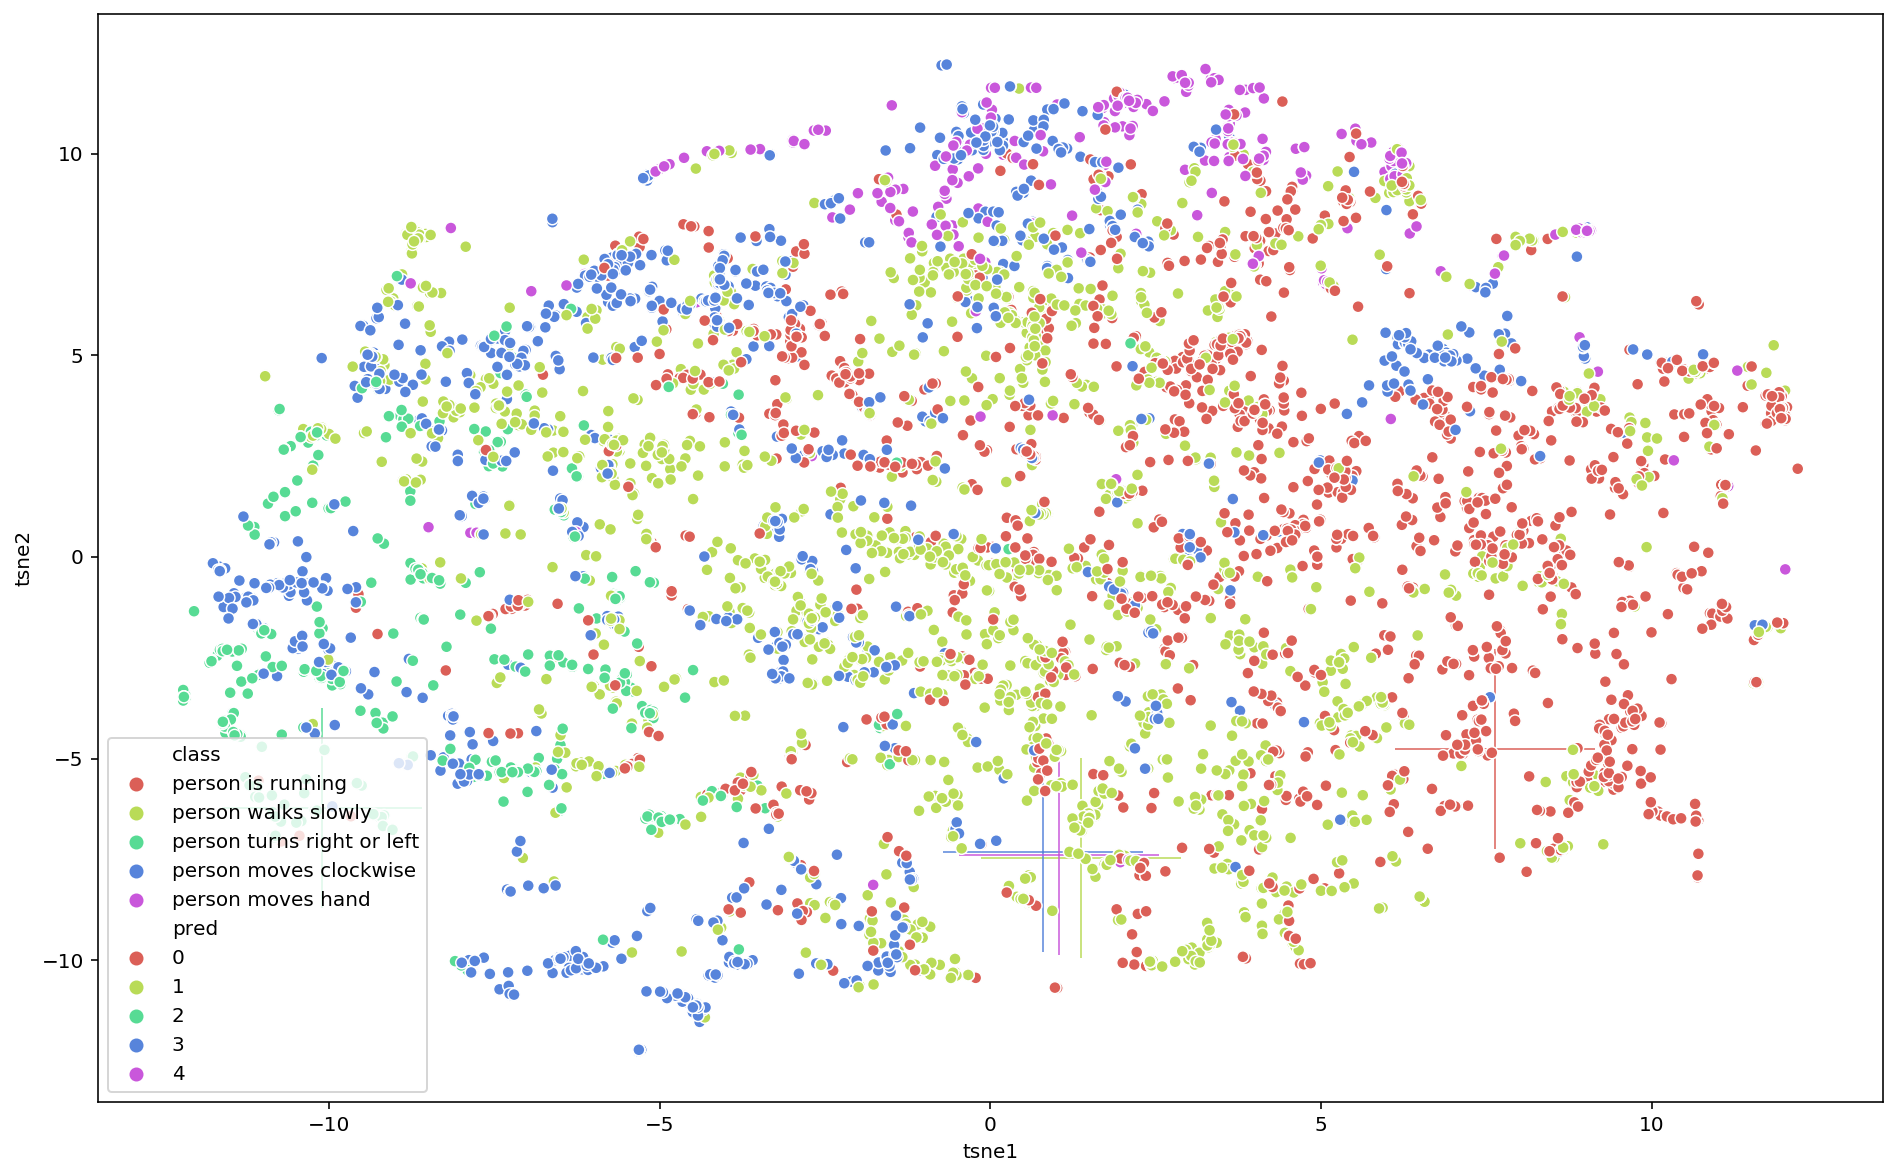

In [578]:
plt.figure(figsize=(16,10))

# plot centroids
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette("hls", true_k),
    data=centroids_df,
    legend="full",
    s=10000,
    marker="+",
    alpha=1.0
);

# plot samples
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=ann_df,
    legend="full",
    alpha=1.0
);